
## Полезные ссылки и литература

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/VAE.ipynb  
Можно сказать что это репост кода + некая творческай постобработка под обновленный keras + tf.

https://keras.io/examples/generative/vae/


#### Литература и ссылки из поста:
Теоретическая часть основана на статье:  
[1] Tutorial on Variational Autoencoders, Carl Doersch, 2016, https://arxiv.org/abs/1606.05908  
и фактически является ее кратким изложением

Многие картинки взяты из блога Isaac Dykeman:  
[2] Isaac Dykeman, http://ijdykeman.github.io/ml/2016/12/21/cvae.html  

Подробнее прочитать про расстояние Кульбака-Лейблера на русском можно здесь   
[3] http://www.machinelearning.ru/wiki/images/d/d0/BMMO11_6.pdf  

Код частично основан на статье *Francois Chollet*:  
[4] https://blog.keras.io/building-autoencoders-in-keras.html  

Другие интересные ссылки:  
http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html  
http://kvfrans.com/variational-autoencoders-explained/  



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import datetime
import copy
from typing import Optional, Tuple, List
import numpy as np
import pandas as pd
import io

from IPython.display import clear_output, display, HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Layer, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau



from data.get_data import get_mnist
from visualization.plot_graph import (
    plot_digits, 
    sapmpling_2d_normal_grid, 
    plot_2d_latent_space_grid,
    draw_manifold,
    combine_two_figures_horisontally,
    create_animation_from_array_of_figures,
    convert_figures_to_array,
)

%matplotlib inline

animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']

# Часть 3: Вариационные автоэнкодеры (VAE)

В прошлой части мы уже обсуждали, что такое скрытые переменные, взглянули на их распределение, а так же поняли, что из распределения скрытых переменных в обычных автоэнкодерах сложно генерировать новые объекты. Для того, чтобы можно было генерировать новые объекты, пространство *скрытых переменных* (*latent variables*) должно быть предсказуемым. 

Имея какое-то одно распределение $Z$ можно получить произвольное другое $X = g(Z)$, например,

пусть $Z$ - обычное нормальное распределение, $g(Z) = \frac{Z}{|Z|}+ \frac{Z}{10}$ - тоже случайное распределение, но выглядит совсем по другому

(-2.0, 2.0)

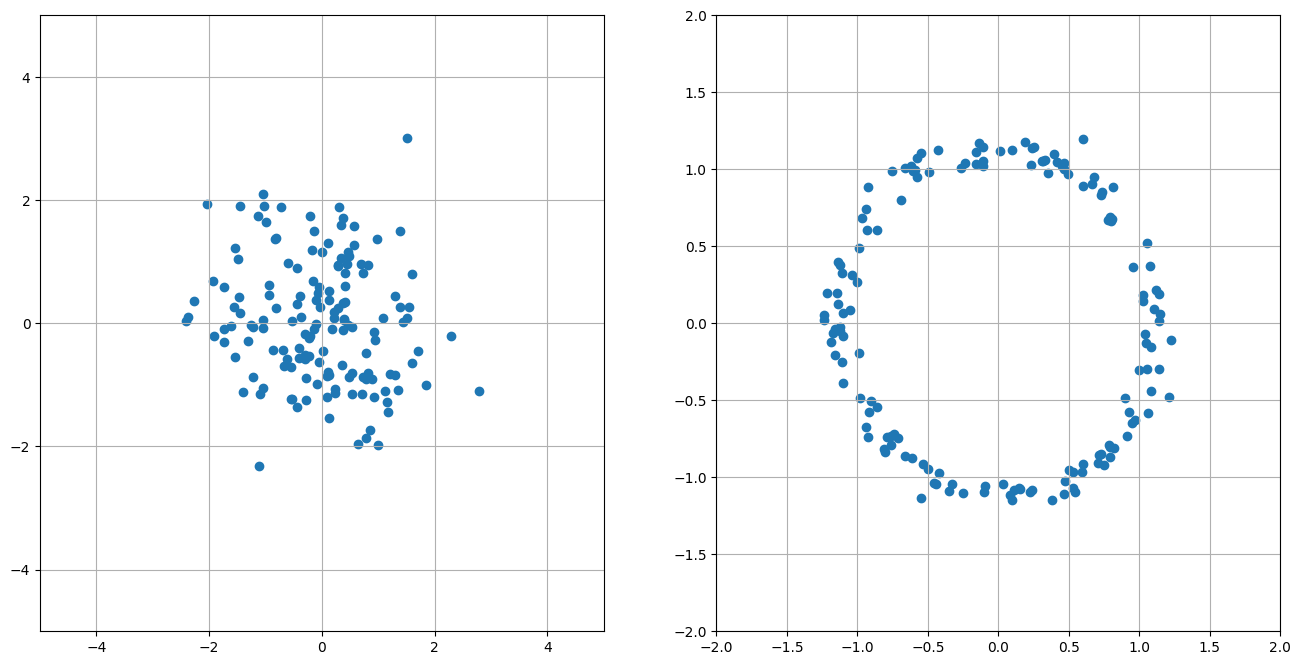

In [3]:
Z = np.random.randn(150, 2)
X = Z/(np.sqrt(np.sum(Z*Z, axis=1))[:, None]) + Z/10

fig, axs = plt.subplots(1, 2, sharex=False, figsize=(16,8))

ax = axs[0]
ax.scatter(Z[:,0], Z[:,1])
ax.grid(True)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax = axs[1]
ax.scatter(X[:,0], X[:,1])
ax.grid(True)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

Пример выше из ***[1]***

Таким образом, если подобрать правильные функции, то можно отобразить пространства скрытых переменных обычных автоэнкодеров в какие-то хорошие пространства, например такие, где распределение нормально. А потом обратно.

С другой стороны специально учиться отображать одни скрытые пространства в другие вовсе не обязательно. Если есть какие-то полезные скрытые пространства, то правильный автоэнкодер научится им по пути сам, но отображать, в конечно итоге, будет в нужное нам пространство.

***Вариационные автоэнкодеры*** (*Variational Autoencoders*) - это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, сэмплить из него. Поэтому *вариационные автоэнкодеры* относят так же к семейству генеративных моделей.

![](pics/03_vae_vae_diagram.png)  

Иллюстрация из ***[2]***

Далее выжимка теории из ***[1]*** лежащая в основе *VAE*.

Пусть $Z$ - скрытые переменные, а $X$ - данные. 
На примере нарисованых цифр рассмотрим естесственный генеративный процесс, который сгенерировал нашу выборку:
$$
P(X) = \int_{z} P(X|Z)P(Z)dZ
$$

- $P(X)$ вероятностное распределение изображений цифр на картинках, т.е. вероятность конкретного изображения цифры впринципе быть нарисованым (если картинка не похожа на цифру, то эта вероятность крайне мала, и наоборот),
- $P(Z)$ - вероятностное распределение скрытых факторов, например, распределение толщины штриха,
- $P(X|Z)$ - распределение вероятности картинок при заданных скрытых факторах, одни и те же факторы могут привезти к разным картинкам (один и тот же человек в одних и тех же условиях не рисует абсолютно одинаковые цифры)

Представим $P(X|Z)$ как сумму некоторой генерирующей функции $f(Z)$ и некоторого сложного шума $\epsilon$

$$
P(X|Z) = f(Z) + \epsilon
$$

Мы хотим построить некоторый искусственный генеративный процесс, который будет создавать объекты близкие в некоторой метрике к тренировачным $X$.

$$
P(X;\theta) = \int_{z} P(X|Z;\theta)P(Z)dZ \ \ \ (1)
$$
и снова
$$
P(X|Z;\theta) = f(Z;\theta) + \epsilon
$$

$f(Z;\theta)$ - некоторое семейсто функций, которое представляет наша модель, а $\theta$ - ее параметры. Выбирая метрику - мы выбираем то, какого вида нам представляется шум $\epsilon$. Если метрика $L_2$, то мы считаем шум нормальным и тогда:

$$
P(X|Z;\theta) = N(X|f(Z;\theta), \sigma^2 I),
$$

По принципу максимального правдоподобия нам остается оптимизировать параметры $\theta$ для того, чтобы максимизировать $P(X)$, т.е. вероятность появления объектов из выборки.

Проблема в том, что оптимизировтаь интеграл (1) напрямую мы не можем: пространство может быть высокоразмерное, объектов много, да и метрика плохая. С другой стороны, если задуматься, то к каждому конкретному $X$ может привезти лишь очень небольшое подмножество $Z$, для остальных же $P(X|Z)$ будет очень близок к нулю. 
И при оптимизации достаточно сэмплить только из хороших $Z$.

Для того чтобы знать из каких $Z$ нам надо сэмплить, введем новое распределение $Q(Z|X)$, которое в зависимости от $X$ будет показывать распределение $Z \sim Q$, которое могло привезти к этому $X$.

Запишем сперва расстояние Кульбака-Лейблера (несимметричная мера "похожести" двух распределений, подробнее ***[3]***) между
$Q(Z|X)$ и реальным $P(Z|X)$:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(Z|X)]
$$

Применяем формулу Байеса:

$$
KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log Q(Z|X) - \log P(X|Z) - \log P(Z)] + \log P(X)
$$

Выделяем еще одно расстояние Кульбака-Лейблера:

$$
KL[Q(Z|X)||P(Z|X)] = KL[Q(Z|X)||\log P(Z)] - \mathbb{E}_{Z \sim Q}[\log P(X|Z)] + \log P(X)
$$

В итоге получаем тождество:

$$
\log P(X) - KL[Q(Z|X)||P(Z|X)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z)] - KL[Q(Z|X)||P(Z)]
$$


Это тождество - краеугольный камень *вариационных автоэнкодеров*, оно верно для любых $Q(Z|X)$ и $P(X,Z)$.

Пусть $Q(Z|X)$ и $P(X|Z)$ зависят от параметров: $Q(Z|X;\theta_1)$ и $P(X|Z;\theta_2)$, а $P(Z)$ - нормальное $N(0,I)$, тогда получаем:

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - KL[Q(Z|X;\theta_1)||N(0,I)]
$$

Взглянем повнимательнее на то, что у нас получилось:
- во-первых, $Q(Z|X;\theta_1)$, $P(X|Z;\theta_2)$ подозрительно похожи на энкодер и декодер (точнее декодер это $f$ в выражении $P(X|Z;\theta_2) = f(Z;\theta_2) + \epsilon$)
- слева в тождестве - значение, которое мы хотим максимизировать для элементов нашей тренировачной выборки $X$ + некоторая ошибка $KL$ ($KL(x,y) \ge 0 \ \ \forall x,y$), которая, будем надеяться, при достаточной емкости $Q$ уйдет в 0,
- справа значение, которое мы можем оптимизировать градиентным спуском, где первый член имеет смысл качества предсказания $X$ декодером по значениям $Z$, а второй член, это расстояние К-Л между распределением $Z \sim Q$, которое предсказывает энкодер для конкретного $X$, и распределением $Z$ для всех $X$ сразу

Для того, чтобы иметь возможность оптимизировать правую часть градиентным спуском, осталось разобраться с двумя вещами:
#### 1. Точнее определим что такое $Q(Z|X;\theta_1)$
Обычно $Q$ выбирается нормальным распределением:

$$
Q(Z|X;\theta_1) = N(\mu(X;\theta_1), \Sigma(X;\theta_1))
$$
То есть энкодер для каждого $X$ предсказывает 2 значения: среднее $\mu$ и вариацию $\Sigma$ нормального распределения, из которого уже сэмплируются значения. Работает это все примерно вот так:   
![](pics/03_vae_encoder_vae_diagram.png)  
Иллюстрация из ***[2]***


При том, что для каждой отдельной точки данных $X$ энкодер предсказывает некоторое нормальное распределение $P(Z|X) = N(\mu(X), \Sigma(X))$, для априорного распределения $Х$: $P(Z) = N(0, I)$, что получается из формулы, и это потрясающе.  
![](pics/03_vae_kl_divergence_diagram.png)  
Иллюстрация из ***[2]***


При этом $KL[Q(Z|X;\theta_1)||N(0,I)]$ принимает вид:  

$$
KL[Q(Z|X;\theta_1)||N(0,I)] = \frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)
$$

#### 2. Разберемся с тем, как распространять ошибки через $\mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)]$
Дело в том, что здесь мы берем случайные значения $Z \sim Q(Z|X;\theta_1)$ и передаем их в декодер.
Ясно, что распросранять ошибки через случайные значения напрямую нельзя, поэтому используется так называемый *трюк с репараметризацией* (*reparametrization trick*).

Схема получается вот такая:  
![](pics/03_vae_reparam_trick.png)  
Иллюстрация из ***[1]***

Здесь на левой картинке схема без трюка, а на правой с трюком.
Красным цветом показано семплирование, а синим вычисление ошибки.  
То есть по сути просто берем предсказанное энкодером стандартное отклонение $\Sigma$ умножаем на случайное число из $N(0,I)$ и добавляем предсказанное среднее $\mu$.

Прямое растространение на обеих схемах абсолютно одинаковое, однако на правой схеме работает обратное распространение ошибки.

После того, как мы обучили такой вариационный автоэнкодер, декодер становится полноправной генеративной моделью. По сути и энкодер то нужен в основном для того, чтобы обучить декодер отдельно быть генеративной моделью.  
![](pics/03_vae_vae_decoder_diagram.png)  
Иллюстрация из ***[2]***  
<img src="./pics/03_vae_generator.png" width="300"/>  
Иллюстрация из ***[1]***  

Но то, что энкодер и декодер вместо образуют еще и полноценный автоэнкодер, это очень приятный плюс.

# VAE в Keras 

Теперь, когда мы разобрались в том, что такое вариационные автоэнкодеры, напишем такой на *Keras*

Зададим основные параметры. Скрытое пространство возьмем размерности 2, чтобы позже генерировать из него и визуализировать результат.  
***Замечание***: размерность 2 крайне мала, особенно в метрике $L_2$, поэтому следует ожидать, что цифры получатся очень размытыми.

In [4]:
x_train, y_train, x_test, y_test = get_mnist()

Напишем модели вариационного автоэнкодера. 

Для того, чтобы обучение происходило быстрее и более качественно, добавим слои *dropout* и *batch normalization*.
А в декодере используем в качестве активации *leaky ReLU*, которую добавляем отдельным слоем после *dense* слоев без активации.

Функция *sampling* реализует сэмплирование значений $Z$ из $Q(X)$ с использованием трюка репараметризации. В Keras реализуется через кастомный слой class SamplingLayer(Layer)

Для того чтобы реализовать свою функцию потерь (правую часть из уравнения ниже) - необходимо будет описать в модели на keras свои функции train_step для тренировки и test_step для валидации.

$$
\log P(X;\theta_2) - KL[Q(Z|X;\theta_1)||P(Z|X;\theta_2)] = \mathbb{E}_{Z \sim Q}[\log P(X|Z;\theta_2)] - \left(\frac{1}{2}\left(tr(\Sigma(X)) + \mu(X)^T\mu(X) - k - \log \det \Sigma(X) \right)\right)
$$

In [5]:
# Необходимые функции и классы для задания для вариационных автоенкодеров

# ========================================================
# Добавление Dropout и BatchNormalization между слоями
def apply_bn_and_dropout(x, dropout_rate: float):
    return Dropout(dropout_rate)(BatchNormalization()(x))


# ========================================================
# Энкодер Dense ==========================================
def create_dense_encoder(latent_dim: int, dropout_rate: float):
    input_img = Input(shape=(28, 28, 1), name="enc_input")
    x = Flatten(name="enc_flatten")(input_img)
    x = Dense(256, activation="relu", name="enc_dense_1")(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    x = Dense(128, activation="relu", name="enc_dense_2")(x)
    x = apply_bn_and_dropout(x, dropout_rate)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение,
    # предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # --------------------------------------------------------
    # Сэмплирование из Q с трюком репараметризации
    # делается через кастомный слой
    class SamplingLayer(Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = SamplingLayer()([z_mean, z_log_var])

    model_encoder = Model(input_img, [z_mean, z_log_var, z], name="Dense_Encoder")
    return model_encoder


# ========================================================
# Декодер Dense ==========================================
def create_dense_decoder(latent_dim: int, dropout_rate: float):
    latent_inputs = Input(shape=(latent_dim,), name="dec_input")
    # x = Dense(128, activation='relu', name="dec_dense_1")(z)
    x = Dense(128, name="dec_dense_1")(latent_inputs)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    # x = Dense(256, activation='relu', name="dec_dense_2")(x)
    x = Dense(256, name="dec_dense_2")(x)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x, dropout_rate)
    x = Dense(28 * 28, activation="sigmoid", name="dec_results")(x)
    decoded = Reshape((28, 28, 1))(x)

    model_decoder = Model(latent_inputs, decoded, name="Dense_Decoder")
    return model_decoder


# ========================================================
# Энкодер Conv2D ==========================================
def create_conv_encoder(latent_dim: int, dropout_rate: float):
    input_img = Input(shape=(28, 28, 1), name="enc_input")
    x = Conv2D(32, 3, activation="relu", strides=2, padding="same", name="Conv_1")(
        input_img
    )
    # x = apply_bn_and_dropout(x, dropout_rate)
    x = Conv2D(64, 3, activation="relu", strides=2, padding="same", name="Conv_2")(x)
    # x = apply_bn_and_dropout(x, dropout_rate)
    x = Flatten(name="Flatten")(x)
    x = Dense(16, activation="relu")(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение,
    # предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # --------------------------------------------------------
    # Сэмплирование из Q с трюком репараметризации
    # делается через кастомный слой
    class SamplingLayer(Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = SamplingLayer()([z_mean, z_log_var])

    model_encoder = Model(input_img, [z_mean, z_log_var, z], name="Conv2D_Encoder")
    return model_encoder


# Декодер Conv2D ==========================================
def create_conv_decoder(latent_dim: int, dropout_rate: float):
    latent_inputs = Input(shape=(latent_dim,), name="dec_input")
    x = Dense(7 * 7 * 64)(latent_inputs)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(
        64, 3, activation="relu", strides=2, padding="same", name="Conv_1"
    )(x)
    x = Conv2DTranspose(
        32, 3, activation="relu", strides=2, padding="same", name="Conv_2"
    )(x)
    decoded = Conv2DTranspose(
        1, 3, activation="sigmoid", padding="same", name="Conv_Fin"
    )(x)
    model_decoder = Model(latent_inputs, decoded, name="Conv2D_decoder")
    return model_decoder


# ========================================================
# Энкодер Conv2D 2========================================
def create_conv_encoder2(latent_dim: int, dropout_rate: float):
    input_img = Input(shape=(28, 28, 1), name="enc_input")
    x = Conv2D(128, (7, 7), activation='relu', padding='same', name="Conv_1")(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same', name="Conv_2")(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное
    x = Conv2D(1, (7, 7), activation='relu', padding='same', name="Conv_3")(x)
    x = Flatten(name="Flatten")(x)
    x = Dense(16, activation="relu")(x)

    
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение,
    # предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # --------------------------------------------------------
    # Сэмплирование из Q с трюком репараметризации
    # делается через кастомный слой
    class SamplingLayer(Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = SamplingLayer()([z_mean, z_log_var])

    model_encoder = Model(input_img, [z_mean, z_log_var, z], name="Conv2D_Encoder")
    return model_encoder

# Декодер Conv2D 2 =========================================
def create_conv_decoder2(latent_dim: int, dropout_rate: float):
    latent_inputs = Input(shape=(latent_dim,), name="dec_input")
    x = Dense(7 * 7 * 1)(latent_inputs)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 1))(x)
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)
    model_decoder = Model(latent_inputs, decoded, name="Conv2D_decoder")
    return model_decoder



# ========================================================
# Модель VAE создается как класс    ======================
# с кастомным train_step (vae-loss) ======================
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def __custom_loss_function(self, x, y_true):
        # Forward pass
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        # Compute loss
        reconstruction_loss = tf.reduce_sum(
            keras.losses.binary_crossentropy(y_true, reconstruction), axis=(1, 2)
        )
        reconstruction_loss = (
            reconstruction_loss / 28 / 28
        )  # reconstruction_loss per pixel
        reconstruction_loss_mean = tf.reduce_mean(reconstruction_loss)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        kl_loss = kl_loss / 28 / 28  # kl_loss per pixel
        kl_loss_mean = tf.reduce_mean(kl_loss)

        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        return reconstruction_loss, kl_loss, total_loss

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to 'fit()'
        x, y = data
        with tf.GradientTape() as tape:
            reconstruction_loss, kl_loss, total_loss = self.__custom_loss_function(x, y)

        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to 'fit()'
        x, y = data
        reconstruction_loss, kl_loss, total_loss = self.__custom_loss_function(x, y)
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        x = inputs
        # Forward pass
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction


Часто в процессе обучения модели требуется выполнять какие-то действия: изменять learning_rate, сохранять промежуточные результаты, сохранять модель, рисовать картинки и т.д.

Для этого в keras есть коллбэки, которые передаются в метод fit перед началом обучения. Например, чтобы влиять на learning rate в процессе обучения есть такие коллбэки, как LearningRateScheduler, ReduceLROnPlateau, чтобы сохранять модель - ModelCheckpoint.

Для случая, когда требуется выполнения произвольных функций в процессе обучения, существует LambdaCallback. Он запускает выполнение произвольных функций в заданные моменты обучения, например между эпохами или батчами.

Частично эти вещи будут использованы в коде ниже, при обучении моделей.

In [6]:
# learning and create figures

def fit_and_collect_learning_history(
    vae_nn: VAE, max_epochs: int, batch_size: int = 256
) -> Tuple[
    List[mpl.figure.Figure],
    List[mpl.figure.Figure],
    List[np.array],
    List[int],
    pd.DataFrame,
]:
    """Fits the `vae_nn` model to training data and collects learning history for visualization.

    Parameters
    ----------
    vae_nn : VAE
        The VAE model to be trained and monitored.
    max_epochs : int
        Maximum number of epochs for training.
    batch_size: int
        The batch size for training (default: 256).

    Returns
    -------
    tuple :
        A tuple containing
            manifold_figs - A list of `matplotlib` figures for the manifold of generated images.
            latent_distrs - A list of `matplotlib` figures for the latent space distribution of test images.
            sample_imgs - A list of np.array for the comparison of real and decoded images from the test set.
            epochs - A list for the epochs.
            vae_train_results_pdf - A pandas DataFrame containing the training history with epochs as index.

    Notes
    -----
    This function fits the `vae_nn` model to training data and collects various data for visualization:
        - Comparison of real and decoded images from the test set
        - Latent space distribution of test images
        - Manifold of generated images

    The `on_epoch_end` callback is defined inside this function and is triggered after each epoch.
    It updates the arrays `manifold_figs`, `latent_distrs`, `sample_imgs`, and `epochs` with the corresponding results
    for visualization purposes.

    The collected data can be used to create animations of the learning process.
    """
    # Массивы в которые будем сохранять результаты,
    # для последующей визуализации
    manifold_figs = []
    latent_distrs = []
    sample_imgs = []
    epochs = []

    # Эпохи в которые будем сохранять
    # Первые 10 подряд, потом с увеличиающимся интервалом
    save_epochs = set(
        list((np.arange(0, 59) ** 1.701).astype(np.int64)) + list(range(10))
    )

    # Отслеживать будем на вот этих цифрах
    imgs = x_test[:batch_size]
    n_compare = 10  # Сколько первых цифр из теста мониторим
    n_count = 15  # Картинка с 15x15 цифр для многообразия

    # Фунция, которую будем запускать после каждой эпохи
    def on_epoch_end(epoch, logs):
        if epoch in save_epochs:
            clear_output()  # Не захламляем output

            # Текущая эпоха
            epochs.append(epoch)

            # Сравнение реальных и декодированных цифр
            decoded = vae_nn.predict(imgs, batch_size=batch_size)
            sample_imgs.append(decoded[:n_compare])

            # Рисование многообразия и диаграммы рассеяния
            z_mean, z_log_var, x_test_encoded = vae_nn.encoder.predict(
                x_test, batch_size=batch_size, verbose=0
            )
            generator = vae_nn.decoder

            grid_x, grid_y = sapmpling_2d_normal_grid(n_count)

            latentspace_fig = plot_2d_latent_space_grid(
                x_test, y_test, x_test_encoded, False, False, True, grid_x, grid_y
            )

            manifold_fig = draw_manifold(generator, grid_x, grid_y, show=False)

            # Сохранение многообразия и диаграмму рассеяния
            # для создания анимации после
            manifold_figs.append(manifold_fig)
            latent_distrs.append(latentspace_fig)

    # callbacks ----------------------------------------------------
    pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

    # Train --------------------------------------------------------
    vae_train_results = vae_nn.fit(
        x_train,
        x_train,
        shuffle=True,
        validation_data=(x_test, x_test),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[pltfig],
        verbose=0,
    )

    vae_train_results_pdf = pd.DataFrame(
        vae_train_results.history, index=vae_train_results.epoch
    )

    return manifold_figs, latent_distrs, sample_imgs, epochs, vae_train_results_pdf


# Create animations of results
def create_animations(
    name: str,
    manifold_figs_list: List[mpl.figure.Figure],
    latent_distrs_list: List[mpl.figure.Figure],
    sample_imgs_list: List[np.array],
    epochs_list: List[int],
    imgs: List[np.array],
) -> None:
    """Create animations from the list of figures, latent distributions and sample images.

    Parameters
    ----------
    name : str
        The name for the animations.
    manifold_figs_list : List[mpl.figure.Figure]
        A list of matplotlib figures that represent the manifold.
    latent_distrs_list : List[mpl.figure.Figure]
        A list of matplotlib figures that represent the latent distributions.
    sample_imgs_list : List[np.array]
        A list of numpy arrays that represent the sample images.
    epochs_list : List[int]
        A list of integers that represent the epochs.
    imgs: List[np.array]
        A list of numpy array that represents true values of compared images

    Returns
    -------
    None
    """

    titles_list = [f"Epoch: {e}" for e in epochs_list]

    # manifold_figs
    _ = create_animation_from_array_of_figures(
        manifold_figs_list,
        titles_list,
        figsize=(6, 6),
        filename=f"./anim/03_{name}_manifold.mp4",
    )

    # latent_distrs
    _ = create_animation_from_array_of_figures(
        latent_distrs_list,
        titles_list,
        figsize=(7, 5),
        filename=f"./anim/03_{name}_latent_distrs.mp4",
    )

    # compare images
    dense_vae_sample_imgs_list = [
        plot_digits(imgs[:10], sample_img[:10], show=False)
        for sample_img in sample_imgs_list
    ]
    _ = create_animation_from_array_of_figures(
        dense_vae_sample_imgs_list,
        titles_list,
        figsize=(8, 2),
        filename=f"./anim/03_{name}_sample_imgs.mp4",
    )

    # combined latent space and manifold
    figsize = (10, 5)
    dense_vae_combined_fig_list = [
        combine_two_figures_horisontally(
            latentspace_fig, manifold_fig, figsize=figsize, show=False
        )
        for latentspace_fig, manifold_fig in zip(latent_distrs_list, manifold_figs_list)
    ]

    _ = create_animation_from_array_of_figures(
        dense_vae_combined_fig_list,
        titles_list,
        figsize=figsize,
        filename=f"./anim/03_{name}_combined.mp4",
    )

In [7]:
# CONSTS

latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001
batch_size = 256

### Dense VAE

**Общая схема** - аналогична стандартному автоэнкодеру  

Вся прелесть именно в энкодере и декодере  
**Encoder**  
![](pics/03_vae_dense_encoder.png)

**Decoder**  
![](pics/03_vae_dense_decoder.png)

In [8]:
%%time

# DENSE_VAE =====================================================
dense_encoder = create_dense_encoder(latent_dim, dropout_rate)
dense_decoder = create_dense_decoder(latent_dim, dropout_rate)

dense_vae = VAE(dense_encoder, dense_decoder, name="VAE")
dense_vae.compile(optimizer=Adam(start_lr), run_eagerly=False)

dense_vae.build(input_shape=(None, 28, 28, 1))
# print(dense_vae.summary())

# Save for Netron visualisation
# dense_vae.encoder.save("../models/03_vae_dense_encoder_model.h5", save_format="h5")
# dense_vae.decoder.save("../models/03_vae_dense_decoder_model.h5", save_format="h5")


# learning -------------------------------------------------------
(
    dense_vae_manifold_figs,
    dense_vae_latent_distrs,
    dense_vae_sample_imgs,
    dense_vae_epochs,
    dense_vae_train_results_pdf,
) = fit_and_collect_learning_history(dense_vae, max_epochs=1000, batch_size=batch_size)

# Save weights -----------------------------------------------------
dense_vae.save_weights("../models/03_dense_vae_weights.h5")
# # after recreate object. Can continue fitting or using model
# dense_vae.load_weights("../models/03_dense_vae_weights.h5") 

# create animations ------------------------------------------------
create_animations(
    "dense_vae",
    dense_vae_manifold_figs,
    dense_vae_latent_distrs,
    dense_vae_sample_imgs,
    dense_vae_epochs,
    x_test[:batch_size],
)

# Epoch 10: 28.10s
# Epoch 100: 4m 10.11s
# Epoch 1000: 1h 3min

1/1 [==============================] - 0s 20ms/step


CPU times: total: 1h 19min 19s
Wall time: 1h 3min 17s


In [9]:
print(dense_vae.summary())

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_Encoder (Functional)  [(None, 2),               235908    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Dense_Decoder (Functional)  (None, 28, 28, 1)         236432    
                                                                 
Total params: 472,346
Trainable params: 470,804
Non-trainable params: 1,542
_________________________________________________________________
None


### Conv2D VAE

**Общая схема** - аналогична стандартному автоэнкодеру  

**Encoder**  
![](pics/03_vae_conv_encoder.png)

**Decoder**  
![](pics/03_vae_conv_decoder.png)

In [10]:
%%time

# CONV_VAE =====================================================
conv_encoder = create_conv_encoder(latent_dim, dropout_rate)
conv_decoder = create_conv_decoder(latent_dim, dropout_rate)

conv_vae = VAE(conv_encoder, conv_decoder, name="Conv2D_VAE")
conv_vae.compile(optimizer=Adam(start_lr), run_eagerly=False)

conv_vae.build(input_shape=(None, 28, 28, 1))
# print(conv_vae.summary())

# Save for Netron visualisation
# conv_vae.encoder.save("../models/03_vae_conv_encoder_model.h5", save_format="h5")
# conv_vae.decoder.save("../models/03_vae_conv_decoder_model.h5", save_format="h5")

# learning -------------------------------------------------------
(
    conv_vae_manifold_figs,
    conv_vae_latent_distrs,
    conv_vae_sample_imgs,
    conv_vae_epochs,
    conv_vae_train_results_pdf,
) = fit_and_collect_learning_history(conv_vae, max_epochs=1000, batch_size=batch_size)

# Save weights -----------------------------------------------------
conv_vae.save_weights("../models/03_conv_vae_weights.h5")
# # after recreate object. Can continue fitting or using model
# conv_vae.load_weights("../models/03_conv_vae_weights.h5") 

# create animations ------------------------------------------------
create_animations(
    "conv_vae",
    conv_vae_manifold_figs,
    conv_vae_latent_distrs,
    conv_vae_sample_imgs,
    conv_vae_epochs,
    x_test[:batch_size],
)

# Epoch 10: 56.67s
# Epoch 100: 10m 13.65s
# Epoch 1000: 1h 55min

1/1 [==============================] - 0s 21ms/step
CPU times: total: 2h 19min 2s
Wall time: 1h 55min 43s


In [11]:
print(conv_vae.summary())

Model: "Conv2D_VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_Encoder (Functional)  [(None, 2),              69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Conv2D_decoder (Functional)  (None, 28, 28, 1)        65089     
                                                                 
Total params: 134,171
Trainable params: 134,165
Non-trainable params: 6
_________________________________________________________________
None



### Conv2D VAE 2

**Общая схема** - аналогична стандартному автоэнкодеру  

**Encoder**  
![](pics/03_vae_conv2_encoder.png)

**Decoder**  
![](pics/03_vae_conv2_decoder.png)

In [12]:
%%time

# CONV_VAE2 =====================================================
conv_encoder2 = create_conv_encoder2(latent_dim, dropout_rate)
conv_decoder2 = create_conv_decoder2(latent_dim, dropout_rate)

conv_vae2 = VAE(conv_encoder2, conv_decoder2, name="Conv2D_VAE_2")
conv_vae2.compile(optimizer=Adam(start_lr), run_eagerly=False)

conv_vae2.build(input_shape=(None, 28, 28, 1))
print(conv_vae2.summary())

# Save for Netron visualisation
# conv_vae2.encoder.save("../models/03_vae_conv2_encoder_model.h5", save_format="h5")
# conv_vae2.decoder.save("../models/03_vae_conv2_decoder_model.h5", save_format="h5")

# learning -------------------------------------------------------
(
    conv_vae2_manifold_figs,
    conv_vae2_latent_distrs,
    conv_vae2_sample_imgs,
    conv_vae2_epochs,
    conv_vae2_train_results_pdf,
) = fit_and_collect_learning_history(conv_vae2, max_epochs=1000, batch_size=batch_size)

# Save weights -----------------------------------------------------
conv_vae2.save_weights("../models/03_conv_vae2_weights.h5")
# # after recreate object. Can continue fitting or using model
# conv_vae2.load_weights("../models/03_conv_vae2_weights.h5") 

# create animations ------------------------------------------------
create_animations(
    "conv_vae2",
    conv_vae2_manifold_figs,
    conv_vae2_latent_distrs,
    conv_vae2_sample_imgs,
    conv_vae2_epochs,
    x_test[:batch_size],
)

# Epoch 10: 3m 7.92s
# Epoch 100: 30m 50.85s
# Epoch 1000: 5h 37min

1/1 [==============================] - 0s 29ms/step
CPU times: total: 6h 14min 56s
Wall time: 5h 37min 1s


In [13]:
print(conv_vae2.summary())

Model: "Conv2D_VAE_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_Encoder (Functional)  [(None, 2),              25253     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Conv2D_decoder (Functional)  (None, 28, 28, 1)        24532     
                                                                 
Total params: 49,791
Trainable params: 49,785
Non-trainable params: 6
_________________________________________________________________
None


### Сравнение

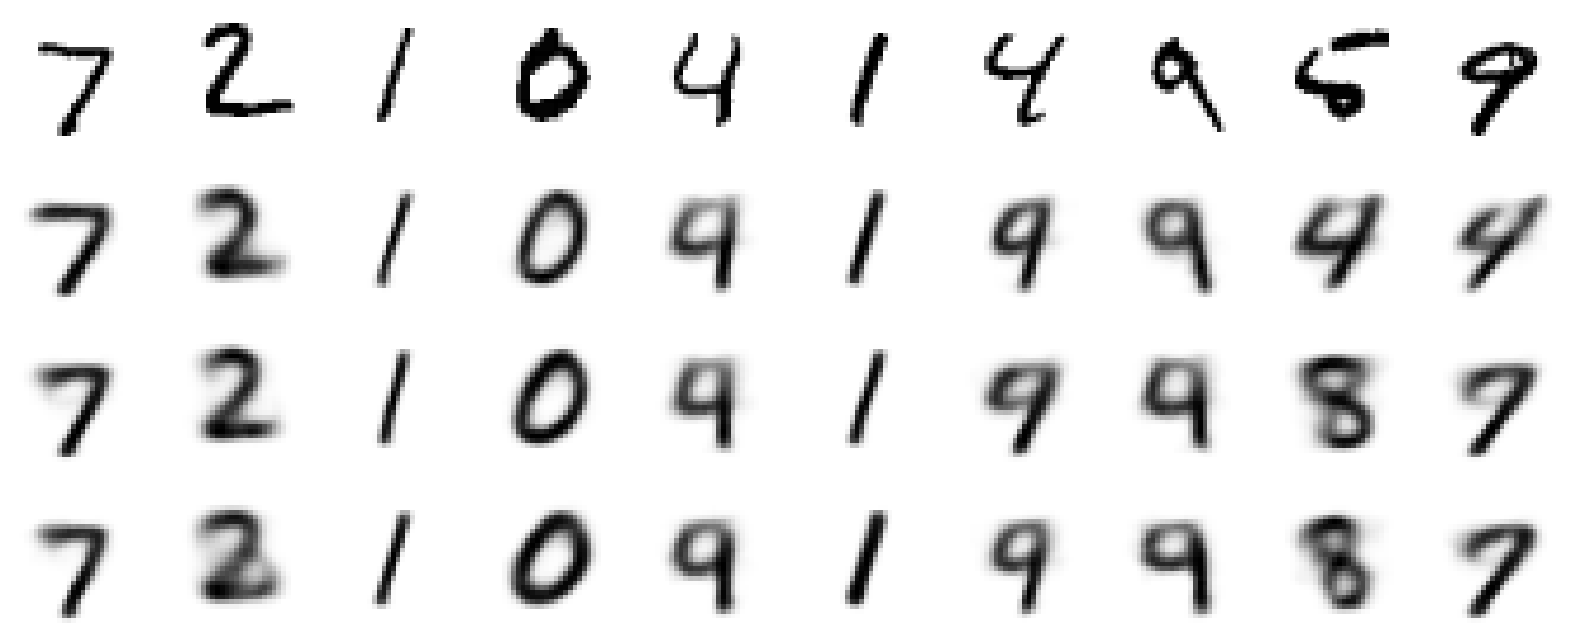

In [19]:
input_images = x_test[:10]
dense_images = dense_vae.predict(input_images, verbose = 0);
conv_images = conv_vae.predict(input_images, verbose = 0);
conv2_images = conv_vae2.predict(input_images, verbose = 0);

plot_digits(input_images, dense_images, conv_images, conv2_images);

In [15]:
print ("losses:" + "="*53)
print("dense_vae:\n", dense_vae_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))
print ("="*60)
print("conv_vae:\n", conv_vae_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))
print ("="*60)
print("conv_vae2:\n", conv_vae2_train_results_pdf.tail(1).to_string(index=False, header=True, line_width=None))

losses:=====================================================
dense_vae:
     loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.173587             0.164641 0.008932  0.186897                 0.178389     0.008846
conv_vae:
    loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.18413              0.17559  0.00857  0.191754                  0.18301      0.00864
conv_vae2:
     loss  reconstruction_loss  kl_loss  val_loss  val_reconstruction_loss  val_kl_loss
0.188113             0.179593   0.0085  0.193819                 0.185518     0.008444


<AxesSubplot:>

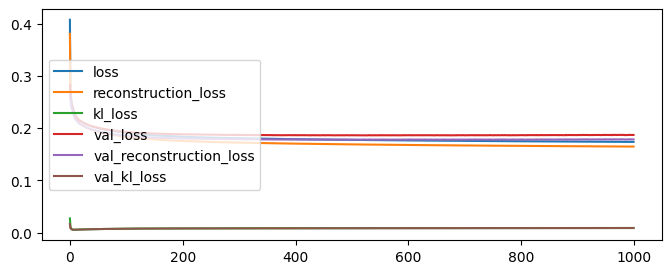

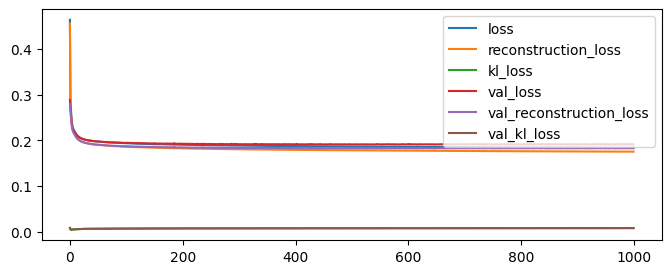

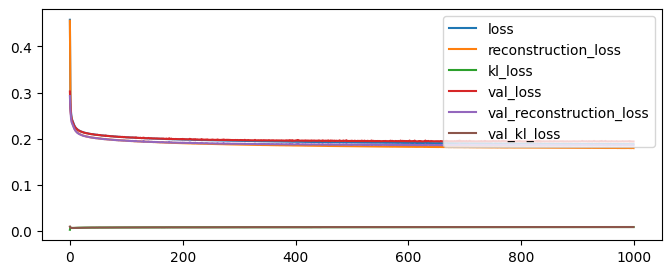

In [16]:
dense_vae_train_results_pdf.plot(figsize=(8,3))
conv_vae_train_results_pdf.plot(figsize=(8,3))
conv_vae2_train_results_pdf.plot(figsize=(8,3))

Dense


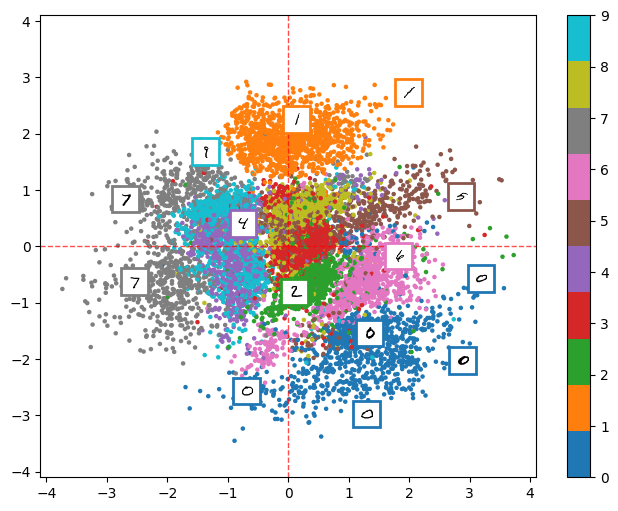

Conv2D


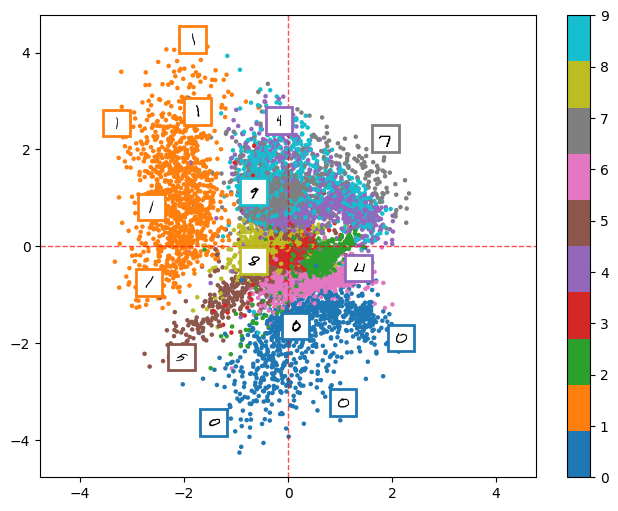

Conv2D 2


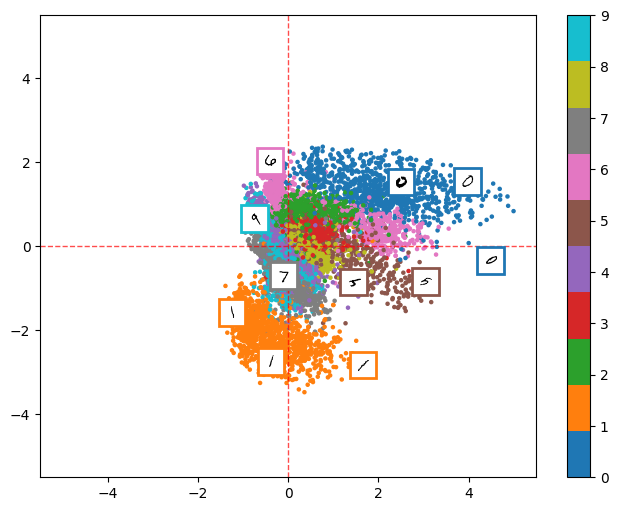

In [20]:
# Dense
print("Dense")
z_mean, z_log_var, x_test_encoded = dense_vae.encoder.predict(
    x_test, batch_size=batch_size, verbose = 0
)
plot_2d_latent_space_grid(x_test, y_test, x_test_encoded, True, True);

#Conv2D
print("Conv2D")
z_mean, z_log_var, x_test_encoded = conv_vae.encoder.predict(
    x_test, batch_size=batch_size, verbose = 0
)
plot_2d_latent_space_grid(x_test, y_test, x_test_encoded, True, True);

#Conv2D 2
print("Conv2D 2")
z_mean, z_log_var, x_test_encoded = conv_vae2.encoder.predict(
    x_test, batch_size=batch_size, verbose = 0
)
plot_2d_latent_space_grid(x_test, y_test, x_test_encoded, True, True);


<!-- <video src="test_animation.mp4" controls> -->


## Video animations

<!-- <video width="500" height="500" controls> -->

#### dense_vae  
<video controls><source src="anim/03_dense_vae_combined.mp4" type="video/mp4"></video>

#### conv_vae  
<video controls><source src="anim/03_conv_vae_combined.mp4" type="video/mp4"></video>

#### conv_vae 2  
<video controls><source src="anim/03_conv_vae2_combined.mp4" type="video/mp4"></video>



# Reset GPU (for debug)

In [18]:
# !pip install numba 

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()